-----------------------------------------------------------------------------------------
Formatação dataset emoUERJ (https://zenodo.org/records/5427549) para um DataFrame

In [ ]:
# - Instalações (necessário rodar uma vez somente)
%pip install pandas

In [28]:
from os import listdir
from os.path import isfile, join
import pandas as pd

train_data_dir = './datasets/fardo/'
label_index_in_filename = 3 + len(train_data_dir)
label_dict = {'n':'neutro', 'a':'raiva', 'h': 'felicidade', 's':'tristeza'}

train_audio_files = [f for f in listdir(train_data_dir) if isfile(join(train_data_dir, f))]

data_list = []
df_data = []
for file in train_audio_files:
  filename = file.replace('.wav','')
  # if "aug" not in filename:
  label_from_filename = filename[label_index_in_filename - len(train_data_dir)]
  data_list.append([file, label_dict[label_from_filename]])

df_data = pd.DataFrame(data_list)
df_data.columns = ['file','label']

-----------------------------------------------------------------------------------------
Data Augmentation

In [ ]:
%pip install audiomentations
%pip install librosa
%pip install soundfile
%pip install audiomentations
%pip install matplotlib

In [6]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import numpy as np
import soundfile as sf
import librosa

# Definição das variações aplicadas
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.01, p=1),
    TimeStretch(min_rate=0.8, max_rate=1, p=1),
    PitchShift(min_semitones=-2, max_semitones=2, p=1),
])

Visualizar o efeito em uma amostra:

In [ ]:
import matplotlib.pyplot as plt

signal, sr = librosa.load("./datasets/emoUERJ/m01a01.wav", sr=None)

# Augment/transform/perturb the audio data
augmented_samples = augment(samples=signal, sample_rate=sr)

# Normalize the signal to the range [-1, 1]
signal_normalized = librosa.util.normalize(augmented_samples)

# Plot the audio waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(signal, sr=sr, color="blue")
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Plot the audio waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(signal_normalized, sr=sr, color="blue")
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

Salvar em um .wav para ouvir:

In [ ]:
# Specify the file path
file_path = "augm_example.wav"

# Save the signal as a WAV file
sf.write(file_path, signal_normalized, sr)

Aplicar em todo o dataset:

In [19]:
augmented_data_list = []
for index, row in df_data.iterrows():
  wav_path = train_data_dir + row['file']
  if "aug" not in wav_path:
    signal, sr = librosa.load(wav_path, sr=None)

    # Aplicar augmentations
    augmented_samples = augment(samples=signal, sample_rate=sr)
    signal_normalized = librosa.util.normalize(augmented_samples)

    file_name = row['file'][:-len(".wav")] + "aug.wav"

    new_wav_path = train_data_dir + file_name
    sf.write(new_wav_path, signal_normalized, sr)
    label_from_filename = wav_path[label_index_in_filename]
    augmented_data_list.append([file_name, label_dict[label_from_filename]])

complete_data_list = data_list + augmented_data_list
df_data = pd.DataFrame(complete_data_list)
df_data.columns = ['file','label']

Visualizar os dados:

In [29]:
df_data

,file,label
0,m01a05_aug.wav,raiva
1,m02a07_aug.wav,raiva
2,m02a07_.wav,raiva
3,m02h08_aug.wav,felicidade
4,m01s12_.wav,tristeza
5,m03n09_aug.wav,neutro
6,m01a05_.wav,raiva
7,m03n09_.wav,neutro
8,m02h08_.wav,felicidade
9,m01s12_aug.wav,tristeza


Visualizar a distribuição de classes:

In [ ]:
# - Instalações (necessário rodar uma vez somente)
%pip install matplotlib

<Axes: >

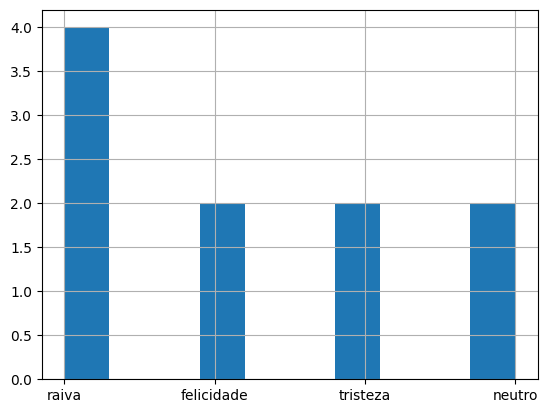

In [30]:
df_data.label.hist()

----------------------------------------------------------------------------------
Extrair features prosódicas (de entonação) com o Praat e Parselmouth - baseado em https://github.com/uzaymacar/simple-speech-features - (tempo médio de 3,1s)

In [ ]:
# - Instalações (necessário rodar uma vez somente)
%pip install praat-parselmouth

Configuração inicial:

In [9]:
import pandas as pd
from utils.prosodic_extraction_utils import *

def extract_prosody(sound_filepath):

  sound = parselmouth.Sound(sound_filepath)
  df = pd.DataFrame()

  attributes = {}

  intensity_attributes = get_intensity_attributes(sound)[0]
  pitch_attributes = get_pitch_attributes(sound)[0]
  attributes.update(intensity_attributes)
  attributes.update(pitch_attributes)

  hnr_attributes = get_harmonics_to_noise_ratio_attributes(sound)[0]
  gne_attributes = get_glottal_to_noise_ratio_attributes(sound)[0]
  attributes.update(hnr_attributes)
  attributes.update(gne_attributes)

  df['local_jitter'] = None
  df['local_shimmer'] = None
  df.at[0, 'local_jitter'] = get_local_jitter(sound)
  df.at[0, 'local_shimmer'] = get_local_shimmer(sound)

  spectrum_attributes = get_spectrum_attributes(sound)[0]
  attributes.update(spectrum_attributes)

  formant_attributes = get_formant_attributes(sound)[0]
  attributes.update(formant_attributes)

  for attribute in attributes:
      df.at[0, attribute] = attributes[attribute]
      
  df.at[0, 'sound_filepath'] = sound_filepath
  rearranged_columns = df.columns.tolist()[-1:] + df.columns.tolist()[:-1]
  df = df[rearranged_columns]
  
  # Adiciona label
  label_from_filename = sound_filepath[label_index_in_filename]
  df['label'] = label_dict[label_from_filename]
  
  return df

Exemplo de extração para uma amostra:

In [12]:
extract_prosody('./datasets/emoUERJ/m01a01.wav')

,sound_filepath,local_jitter,local_shimmer,min_intensity,relative_min_intensity_time,max_intensity,relative_max_intensity_time,mean_intensity,stddev_intensity,q1_intensity,...,f2_median,f3_median,f4_median,formant_dispersion,average_formant,mff,fitch_vtl,delta_f,vtl_delta_f,label
0,./datasets/emoUERJ/m01a01.wav,0.022391,0.147536,40.530746,0.165421,79.471716,0.570432,62.984094,8.991442,57.446197,...,1897.284531,2634.938182,3420.449821,948.752852,2131.71595,1770.152471,15.896299,1032.949631,16.941775,raiva


Extração para todo o dataset (aprox. 20 minutos):

In [31]:
sample_df_list = []
for index, row in df_data.iterrows():
  wav_file = train_data_dir + row['file']
  print(f"Sample {index}")
  sample_df_features = extract_prosody(wav_file) # Extração de features
  sample_df_list.append(sample_df_features)

print(f"*** Extraction finished ***")

df_praat = pd.concat(sample_df_list).reset_index(drop=True)

df_praat

Sample 0
Sample 1
Sample 3
Sample 5
Sample 9
*** Extraction finished ***


,sound_filepath,local_jitter,local_shimmer,min_intensity,relative_min_intensity_time,max_intensity,relative_max_intensity_time,mean_intensity,stddev_intensity,q1_intensity,...,f2_median,f3_median,f4_median,formant_dispersion,average_formant,mff,fitch_vtl,delta_f,vtl_delta_f,label
0,./datasets/fardo/m01a05_aug.wav,0.023649,0.167699,59.919845,0.355087,87.831338,0.516509,72.749890,6.989506,67.167533,...,2075.612555,2890.386910,3978.766308,1161.226032,2359.963496,1854.100718,15.212772,1167.267252,14.992282,raiva
1,./datasets/fardo/m02a07_aug.wav,0.025691,0.127432,60.548320,0.643117,88.521355,0.687095,74.325770,7.456331,66.291301,...,1908.469469,2858.538172,3977.481457,1132.214368,2331.331863,1884.183366,14.880782,1153.364472,15.173001,raiva
2,./datasets/fardo/m02h08_aug.wav,0.01842,0.135086,60.816414,0.972306,86.842735,0.728958,71.787944,8.518620,62.908728,...,1738.276862,2799.765079,4142.641127,1185.104576,2317.002617,1855.023983,15.102680,1161.892173,15.061639,felicidade
3,./datasets/fardo/m03n09_aug.wav,0.01981,0.121269,56.477991,0.972401,85.785867,0.750917,74.214483,8.340130,67.889370,...,1841.484482,2717.450916,3817.086957,1108.611699,2216.818554,1750.215431,16.053089,1102.918300,15.866996,neutro
4,./datasets/fardo/m01s12_aug.wav,0.024207,0.11768,59.323894,0.412702,85.209338,0.638796,71.641495,7.561251,63.279127,...,1955.873110,2876.894597,3716.924939,1093.978144,2246.170788,1736.728972,16.305636,1112.037081,15.736885,tristeza


Salvar em um .csv:

In [33]:
df_praat.to_csv("features/" + train_data_dir[-8:-1] + '_features/aug_praat_features.csv',index=False)

----------------------------------------------------------------------------------
Extrair features com o TSFEL (tempo médio de 20,38s)

In [ ]:
# - Instalações (necessário rodar uma vez somente)
%pip install tsfel
%pip install pandas
%pip install librosa

Configuração inicial:

In [61]:
# Imports
import tsfel
import pandas as pd
import librosa

# Retrieves a pre-defined feature configuration file to extract all available features
cfg = tsfel.get_features_by_domain()

def extract_tsfel(wav_file):
    # Carregar os dados, converter em sinal e salvar em serie temporal num dataframe
    signal, sr = librosa.load(wav_file, sr=None)
    time_index = pd.date_range(start=0, periods=len(signal), freq=f"{int(1/sr*(10**9))}N")
    numeric_time_index = time_index.astype(int)
    df = pd.DataFrame(data={"Time": numeric_time_index, "Signal": signal})
    
    sample_df_features = tsfel.time_series_features_extractor(cfg, df) # Extração de features
    
    # Adiciona nome do arquivo e label
    sample_df_features.at[0, 'sound_filepath'] = wav_file[len(train_data_dir):]
    label_from_filename = wav_file[label_index_in_filename]
    sample_df_features.at[0, 'label'] = label_dict[label_from_filename]
    
    return sample_df_features

Exemplo de extração para uma amostra:

In [62]:
extract_tsfel('./datasets/emoUERJ/m01a01.wav')

*** Feature extraction started ***


/tmp/ipykernel_8569/3216378225.py:16: UserWarning: Using default sampling frequency set in configuration file.
  sample_df_features = tsfel.time_series_features_extractor(cfg, df) # Extração de features



*** Feature extraction finished ***


,Signal_Absolute energy,Signal_Area under the curve,Signal_Autocorrelation,Signal_Average power,Signal_Centroid,Signal_ECDF Percentile Count_0,Signal_ECDF Percentile Count_1,Signal_ECDF Percentile_0,Signal_ECDF Percentile_1,Signal_ECDF_0,...,Time_Wavelet variance_2,Time_Wavelet variance_3,Time_Wavelet variance_4,Time_Wavelet variance_5,Time_Wavelet variance_6,Time_Wavelet variance_7,Time_Wavelet variance_8,Time_Zero crossing rate,sound_filepath,label
0,347.448257,34.038202,347.448257,0.315149,549.782205,22050.0,88200.0,-0.021286,0.023743,0.000009,...,1.724520e+14,3.047032e+14,4.747525e+14,6.825949e+14,9.282290e+14,1.211654e+15,1.532869e+15,1.0,m01a01.wav,raiva


Extração para todo o dataset (aprox. 120 minutos):

In [ ]:

sample_df_list = []
for index,row in df_data.iterrows():
    print(f"Sample {index}")
    wav_file = train_data_dir + row['file']
    sample_df_features = extract_tsfel(wav_file)
    sample_df_list.append(sample_df_features)

df_tsfel = pd.concat(sample_df_list).reset_index(drop=True)

df_tsfel

Salvar em um .csv:

In [68]:
df_tsfel.to_csv(train_data_dir[:-1] + '_features/tsfel_features.csv',index=False)

./emoUERJ_features/tsfel_features.csv


----------------------------------------------------------------------------------
Extrair features com o pyAudioAnalysis (tempo médio de 0,85s)

In [ ]:
# - Instalações (necessário rodar uma vez somente)
%pip install pyAudioAnalysis
%pip install eyed3
%pip install pydub
%pip install tdqm
%pip install matplotlib
%pip install numpy

Configuração inicial:

In [63]:
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures
import matplotlib.pyplot as plt
import numpy as np

def extract_pyaudio(wav_file):
    freq_amost, signal = audioBasicIO.read_audio_file(wav_file)
    signal = audioBasicIO.stereo_to_mono(signal)
    
    # Extract short-term features
    win, step = 0.050 * freq_amost, 0.025 * freq_amost
    features, feat_names = ShortTermFeatures.feature_extraction(signal, freq_amost, win, step)

    # Flatten each row of the feature matrix
    features_mean = np.mean(features, axis=1)

    df = pd.DataFrame()
    for index, attribute in enumerate(feat_names):
        df.at[0, attribute] = features_mean[index]
        
    df.at[0, 'sound_filepath'] = wav_file[len(train_data_dir):]
    label_from_filename = wav_file[label_index_in_filename]
    df.at[0, 'label'] = label_dict[label_from_filename]
    
    return df

Exemplo de extração para uma amostra:

In [64]:
extract_pyaudio('./datasets/emoUERJ/m01a01.wav')

/home/gustavo/projeto-embarcado-ima/.venv/lib/python3.9/site-packages/pyAudioAnalysis/audioBasicIO.py:99: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, signal = wavfile.read(input_file) # from scipy.io


,zcr,energy,energy_entropy,spectral_centroid,spectral_spread,spectral_entropy,spectral_flux,spectral_rolloff,mfcc_1,mfcc_2,...,delta chroma_6,delta chroma_7,delta chroma_8,delta chroma_9,delta chroma_10,delta chroma_11,delta chroma_12,delta chroma_std,sound_filepath,label
0,0.087985,0.003985,2.942968,0.159956,0.161525,0.814258,0.003888,0.137619,-28.119707,1.247647,...,0.000008,0.000016,0.000027,0.000321,0.000149,0.000039,0.000027,-0.000311,m01a01.wav,raiva


Extração para todo o dataset (aprox. 5:30 minutos):

In [ ]:
sample_df_list = []
for index,row in df_data.iterrows():
    print(f"Sample {index}")
    wav_file = train_data_dir + row['file']
    sample_df_features = extract_pyaudio(wav_file)
    sample_df_list.append(sample_df_features)
    
print(f"*** Extraction finished ***")

df_pyaudio = pd.concat(sample_df_list).reset_index(drop=True)

df_pyaudio

Salvar em um .csv:

In [ ]:
df_pyaudio.to_csv(train_data_dir[:-1] + '_features/pyaudioanalysis_features.csv',index=False)